In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['axes.grid'] = False
plt.style.context('Solarize_Light2')

roots = [0.3018336135076354, 0.7883671029813581, 0.9723445185469877, 1.2390777517571931, 1.6410179299284857, 1.9728374883141215, 2.2691853142129728]
ms = [0.0004, 0.0625, 0.125, 0.25, 0.5, 0.75, 1.0]
get_crit_T = dict(zip(ms, roots))
num_temps = 100
num_epochs = 3

In [13]:
def errs(errs):
    return np.array([sum(errs[i*512:(i+1)*512])/512 for i in range(num_temps)])

def stds_outs(outs):
    return np.power(np.array([np.std(outs[i*512:(i+1)*512]) for i in range(num_temps)]), 2)

In [14]:
df_res = pd.DataFrame(columns=['M', 'L', '\mu', 'T_c', '\sigma', '\sigma_r', '\sigma_l'])

In [31]:
M = 1.0
T_c = get_crit_T[M]
T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

errs_ = []
outs_ = []
Ls = [20, 30, 60, 80, 100]
#epochs = [3] * len(Ls)

for i, L in enumerate(Ls):
    with open(f'data_errors/square/{M}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
        errs_.append(np.load(f)) 
    with open(f'data_outputs/square/{M}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
        outs_.append(np.squeeze(np.load(f)))

(5, 3) (5, 3, 3)


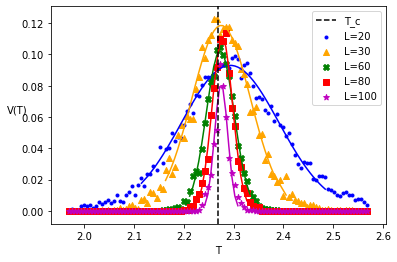

In [32]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return (amp/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2 / (2*sigma**2))


def gaussian_fit(x, y):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False, maxfev=100000)
    return popt, pcov

def gaussian_fit_with_p(x, y, p):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False, p0=p, maxfev=100000)
    return popt, pcov

#p_ = [[np.max(errs(errs_[j])), T[np.argmax(errs(errs_[j]))], np.std(errs(errs_[j])) / 2] for j in range(len(Ls))]
p_ = [[np.max(stds_outs(outs_[j][:, 0])), T[np.argmax(stds_outs(outs_[j][:, 0]))], np.std(stds_outs(outs_[j][:, 0])) / 2] for j in range(len(Ls))]


#data = [stds_outs(outs_[j][:, 0]) for j in range(len(Ls))]

# if M in [0.0625, 0.125]:
#     threshold = 0.1
# else:
#     threshold = 0.05

#threshold = [0.1, 0.1, 0.05, 0.05, 0.01]
threshold = [0.02, 0.02, 0.01, 0.01, 0.005]
#threshold = [0.0, 0.0, 0.0, 0.0, 0.0]

data = [stds_outs(outs_[j][:, 0])[stds_outs(outs_[j][:, 0]) > threshold[j]] for j in range(len(Ls))]
temp = [T[stds_outs(outs_[j][:, 0]) > threshold[j]] for j in range(len(Ls))]


#tmp = [gaussian_fit_with_p(y=errs(errs_[j]), x=T, p=p_[j]) for j in range(len(Ls))]
tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
#tmp = [gaussian_fit(y=data[j], x=temp[j]) for j in range(len(Ls))]

popt_ = np.array([tmp[j][0] for j in range(len(Ls))])
pcov_ = np.array([tmp[j][1] for j in range(len(Ls))])

print(popt_.shape, pcov_.shape)

with open(f'var_params/square/popt_{M}.npy', 'wb') as f:
    np.save(f, popt_)

with open(f'var_params/square/pcov_{M}.npy', 'wb') as f:
    np.save(f, pcov_)

plt.figure()

markers=['.', '^', 'X', 's', '*']
colors=['blue', 'orange', 'green', 'red', 'm']

for j in range(len(Ls)):
    plt.plot(temp[j], gaussian(temp[j], popt_[j][0], popt_[j][1], popt_[j][2]), c=colors[j])
    plt.scatter(T, stds_outs(outs_[j][:, 0]), marker=markers[j], c=colors[j], label=f'L={Ls[j]}')
    
    #plt.scatter(T, stds_outs(outs_[j][:, 0]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    #plt.scatter(T, errs(errs_[j]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')

plt.axvline(x=T_c, color='black', linestyle='--', label='T_c')

#plt.axvline(x=popt_[2][1] - 3*popt_[2][2], color='blue', linestyle='-')
#plt.axvline(x=popt_[2][1] + 3*popt_[2][2], color='blue', linestyle='-')

#plt.title(f'M = {M}')
plt.xlabel('T')
plt.ylabel('V(T)', rotation='horizontal', )
#plt.yticks(rotation='vertical')
plt.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

In [163]:
perr_ = np.array([np.sqrt(np.diag(pcov_[j, :])) for j in range(len(Ls))])
popt_, perr_

(array([[0.10908452, 2.29596274, 0.14465063],
        [0.07377963, 2.27496616, 0.08659679],
        [0.03282764, 2.27285376, 0.04147746],
        [0.02546437, 2.2776159 , 0.0312531 ],
        [0.01506701, 2.27535766, 0.02251011]]),
 array([[0.00099016, 0.0013462 , 0.00169443],
        [0.00098469, 0.00118732, 0.00148662],
        [0.00040778, 0.00057376, 0.00062911],
        [0.00039658, 0.00055056, 0.00058261],
        [0.00046312, 0.0007984 , 0.00080001]]))

In [164]:
df = pd.DataFrame(columns=['M', 'L', '\mu', 'T_c', '\sigma', '\sigma_r', '\sigma_l'])
df['M'] = [M]*len(Ls)
df['L'] = [20,30,60,80,100]

mus = []
for i in range(popt_[:, 1].shape[0]):
    mus.append(str(round(popt_[i, 1], 4)) + '(' + str(round(perr_[i, 1], 4)) + ')')
    
df['\mu'] = mus 
df['T_c'] = np.round([T_c]*len(Ls), 3)

sigmas = []
for i in range(popt_[:, 2].shape[0]):
    sigmas.append(str(round(popt_[i, 2], 4)) + '(' + str(round(perr_[i, 2], 4)) + ')')
    
df['\sigma'] = sigmas

In [165]:
df

,M,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,1.0,20,2.296(0.0013),2.269,0.1447(0.0017),NaN,NaN
1,1.0,30,2.275(0.0012),2.269,0.0866(0.0015),NaN,NaN
2,1.0,60,2.2729(0.0006),2.269,0.0415(0.0006),NaN,NaN
3,1.0,80,2.2776(0.0006),2.269,0.0313(0.0006),NaN,NaN
4,1.0,100,2.2754(0.0008),2.269,0.0225(0.0008),NaN,NaN


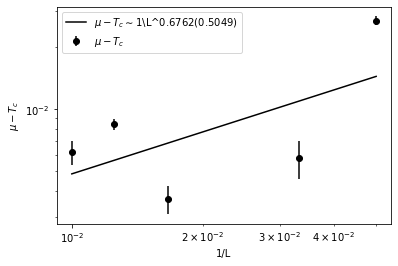

In [166]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = np.array([1/L for L in [20, 30, 60, 80, 100]])
#cs_ = np.array(popt_)[:, 1]  # mu 
cs_ = np.array(popt_)[:, 1] - T_c # mu - tc

pl_, pcov_ = line_fit(y=np.log(np.abs(cs_)), x=np.log(ls))

perr_line = np.sqrt(np.diag(pcov_))

#plt.scatter(ls, cs, color='red')
plt.errorbar(ls, cs_, yerr=perr_[:, 1], fmt="o", color='black', label='$\mu-T_c$')

plt.plot(ls, np.exp(line(np.log(ls), pl_[0], pl_[1])), color='black', label='$\mu-T_c\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_[0], 4), round(perr_line[0], 4)))

#plt.title(f'M = {M}')
plt.xlabel('1/L')
plt.ylabel('$\mu-T_c$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig(f'images/{M}-mu.png')

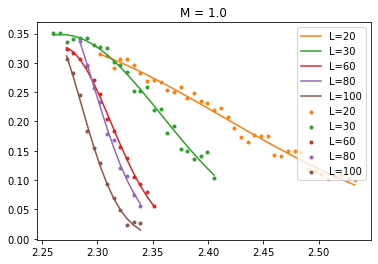

In [167]:
data = []

for j in range(len(Ls)):
    dt = stds_outs(outs_[j][:, 0])[T >= T[np.argmin(np.abs(stds_outs(outs_[j][:, 0]) - popt_[j, 1]))]] 
    data.append(dt[dt >= threshold[j]])
temp = [T[T >= T[np.argmin(np.abs(stds_outs(outs_[j][:, 0]) - popt_[j, 1]))]][:data[j].shape[0]] for j in range(len(Ls))]


p_ = [[np.max(stds_outs(outs_[j][:, 0])), T[np.argmax(stds_outs(outs_[j][:, 0]))], np.std(stds_outs(outs_[j][:, 0])) / 2] for j in range(len(Ls))]

#tmp = [gaussian_fit_with_p(y=errs(errs_[j]), x=T, p=p_[j]) for j in range(len(Ls))]
tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
#tmp = [gaussian_fit(y=data[j], x=temp[j]) for j in range(len(Ls))]

popt_r = np.array([tmp[j][0] for j in range(len(Ls))])
pcov_r = np.array([tmp[j][1] for j in range(len(Ls))])

plt.figure()

for j in range(len(Ls)):
    plt.plot(temp[j], gaussian(temp[j], popt_r[j][0], popt_r[j][1], popt_r[j][2]), label=f'L={Ls[j]}', c=f'C{j+1}')
    plt.scatter(temp[j], data[j], label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    
    #plt.scatter(T, stds_outs(outs_[j][:, 0]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    #plt.scatter(T, errs(errs_[j]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')

#plt.axvline(x=T_c, color='black', linestyle='--')

#plt.axvline(x=popt_[2][1] - 3*popt_[2][2], color='blue', linestyle='-')
#plt.axvline(x=popt_[2][1] + 3*popt_[2][2], color='blue', linestyle='-')

plt.title(f'M = {M}')
plt.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

In [168]:
perr_r = np.array([np.sqrt(np.diag(pcov_r[j, :])) for j in range(len(Ls))])

popt_r, perr_r
# for j in range(len(Ls)):
#     print(popt_[j, 2], perr_[j, 2])

(array([[0.16526235, 2.22099932, 0.19147052],
        [0.078986  , 2.26732344, 0.090474  ],
        [0.03616063, 2.26806947, 0.04407692],
        [0.04695771, 2.25307443, 0.04290085],
        [0.03276293, 2.2508052 , 0.03465981]]),
 array([[0.0207956 , 0.02547608, 0.01363112],
        [0.00468903, 0.00560132, 0.00448419],
        [0.00179412, 0.00243948, 0.00155849],
        [0.01304119, 0.0122876 , 0.00512522],
        [0.00696039, 0.00779442, 0.00331968]]))

In [169]:
sigmas = []
for i in range(popt_r[:, 2].shape[0]):
    sigmas.append(str(round(popt_r[i, 2], 4)) + '(' + str(round(perr_r[i, 2], 4)) + ')')
    
df['\sigma_r'] = sigmas
df

,M,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,1.0,20,2.296(0.0013),2.269,0.1447(0.0017),0.1915(0.0136),NaN
1,1.0,30,2.275(0.0012),2.269,0.0866(0.0015),0.0905(0.0045),NaN
2,1.0,60,2.2729(0.0006),2.269,0.0415(0.0006),0.0441(0.0016),NaN
3,1.0,80,2.2776(0.0006),2.269,0.0313(0.0006),0.0429(0.0051),NaN
4,1.0,100,2.2754(0.0008),2.269,0.0225(0.0008),0.0347(0.0033),NaN


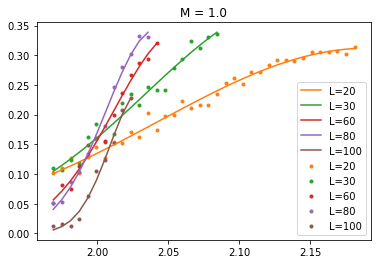

In [170]:
data = []

for j in range(len(Ls)):
    dt = stds_outs(outs_[j][:, 0])[T < T[np.argmin(np.abs(stds_outs(outs_[j][:, 0]) - popt_[j, 1]))]] 
    data.append(dt[dt >= threshold[j]])
temp = [T[T < T[np.argmin(np.abs(stds_outs(outs_[j][:, 0]) - popt_[j, 1]))]][:data[j].shape[0]] for j in range(len(Ls))]


p_ = [[np.max(data[j]), T[np.argmax(stds_outs(outs_[j][:, 0]))], np.std(data[j])] for j in range(len(Ls))]

tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
#tmp = [gaussian_fit(y=data[j], x=temp[j]) for j in range(len(Ls))]

popt_l = np.array([tmp[j][0] for j in range(len(Ls))])
pcov_l = np.array([tmp[j][1] for j in range(len(Ls))])

plt.figure()

for j in range(len(Ls)):
    plt.plot(temp[j], gaussian(temp[j], popt_l[j][0], popt_l[j][1], popt_l[j][2]), label=f'L={Ls[j]}', c=f'C{j+1}')
    plt.scatter(temp[j], data[j], label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    
    #plt.scatter(T, stds_outs(outs_[j][:, 0]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    #plt.scatter(T, errs(errs_[j]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')

#plt.axvline(x=T_c, color='black', linestyle='--')

#plt.axvline(x=popt_[2][1] - 3*popt_[2][2], color='blue', linestyle='-')
#plt.axvline(x=popt_[2][1] + 3*popt_[2][2], color='blue', linestyle='-')

plt.title(f'M = {M}')
plt.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

In [171]:
perr_l = np.array([np.sqrt(np.diag(pcov_l[j, :])) for j in range(len(Ls))])

popt_l, perr_l
# for j in range(len(Ls)):
#     print(popt_[j, 2], perr_[j, 2])

(array([[0.11558418, 2.19143548, 0.14776938],
        [0.10257493, 2.13971134, 0.10520057],
        [0.04113205, 2.05998773, 0.04777299],
        [0.03021484, 2.0417366 , 0.03509951],
        [0.01408237, 2.03216672, 0.02304703]]),
 array([[0.0073177 , 0.00979626, 0.0070343 ],
        [0.03384624, 0.03641312, 0.01841467],
        [0.0085345 , 0.01078721, 0.00564185],
        [0.00316762, 0.00414657, 0.00245606],
        [0.003271  , 0.00598804, 0.00304139]]))

In [172]:
sigmas = []
for i in range(popt_r[:, 2].shape[0]):
    sigmas.append(str(round(popt_l[i, 2], 4)) + '(' + str(round(perr_l[i, 2], 4)) + ')')
    
df['\sigma_l'] = sigmas
df

,M,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,1.0,20,2.296(0.0013),2.269,0.1447(0.0017),0.1915(0.0136),0.1478(0.007)
1,1.0,30,2.275(0.0012),2.269,0.0866(0.0015),0.0905(0.0045),0.1052(0.0184)
2,1.0,60,2.2729(0.0006),2.269,0.0415(0.0006),0.0441(0.0016),0.0478(0.0056)
3,1.0,80,2.2776(0.0006),2.269,0.0313(0.0006),0.0429(0.0051),0.0351(0.0025)
4,1.0,100,2.2754(0.0008),2.269,0.0225(0.0008),0.0347(0.0033),0.023(0.003)


In [173]:
df_res = pd.concat([df_res,df])
df_res

,M,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,0.7500,20,1.9987(0.0014),1.973,0.1264(0.0018),0.1468(0.0104),0.1248(0.0093)
1,0.7500,30,1.9782(0.0008),1.973,0.0758(0.001),0.075(0.0032),0.0921(0.01)
2,0.7500,60,1.9762(0.0005),1.973,0.0364(0.0006),0.0398(0.0026),0.0411(0.0037)
3,0.7500,80,1.9797(0.0006),1.973,0.0265(0.0006),0.0326(0.0028),0.0273(0.0028)
4,0.7500,100,1.9774(0.0005),1.973,0.0222(0.0005),0.0268(0.0022),0.0264(0.0041)
0,0.0625,20,0.8132(0.0012),0.788,0.0967(0.0016),0.1229(0.0139),0.0863(0.003)
1,0.0625,30,0.8191(0.0008),0.788,0.0518(0.0009),0.0584(0.0053),0.0464(0.0021)
2,0.0625,60,0.8273(0.0005),0.788,0.0247(0.0006),0.0273(0.0024),0.0201(0.001)
3,0.0625,80,0.8236(0.0006),0.788,0.0217(0.0007),0.0249(0.0019),0.0224(0.0055)
4,0.0625,100,0.8135(0.0005),0.788,0.0182(0.0005),0.0184(0.0013),0.0277(0.0025)


In [174]:
print(df_res.to_latex(index=False)) 

\begin{tabular}{rllrlll}
\toprule
     M &   L &            \textbackslash mu &   T\_c &         \textbackslash sigma &       \textbackslash sigma\_r &       \textbackslash sigma\_l \\
\midrule
0.7500 &  20 & 1.9987(0.0014) & 1.973 & 0.1264(0.0018) & 0.1468(0.0104) & 0.1248(0.0093) \\
0.7500 &  30 & 1.9782(0.0008) & 1.973 &  0.0758(0.001) &  0.075(0.0032) &   0.0921(0.01) \\
0.7500 &  60 & 1.9762(0.0005) & 1.973 & 0.0364(0.0006) & 0.0398(0.0026) & 0.0411(0.0037) \\
0.7500 &  80 & 1.9797(0.0006) & 1.973 & 0.0265(0.0006) & 0.0326(0.0028) & 0.0273(0.0028) \\
0.7500 & 100 & 1.9774(0.0005) & 1.973 & 0.0222(0.0005) & 0.0268(0.0022) & 0.0264(0.0041) \\
0.0625 &  20 & 0.8132(0.0012) & 0.788 & 0.0967(0.0016) & 0.1229(0.0139) &  0.0863(0.003) \\
0.0625 &  30 & 0.8191(0.0008) & 0.788 & 0.0518(0.0009) & 0.0584(0.0053) & 0.0464(0.0021) \\
0.0625 &  60 & 0.8273(0.0005) & 0.788 & 0.0247(0.0006) & 0.0273(0.0024) &  0.0201(0.001) \\
0.0625 &  80 & 0.8236(0.0006) & 0.788 & 0.0217(0.0007) & 0.0249(0.0019

In [175]:
cs_

array([0.02677743, 0.00578084, 0.00366844, 0.00843059, 0.00617235])

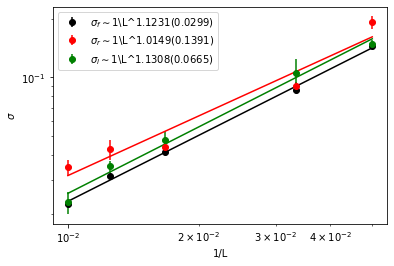

In [176]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = np.array([1/L for L in [20, 30, 60, 80, 100]])
cs_ = np.abs(np.array(popt_)[:, 2]) # sigma 
cs_r = np.abs(np.array(popt_r)[:, 2]) # sigma 
cs_l = np.abs(np.array(popt_l)[:, 2]) # sigma 

pl_, pcov_ = line_fit(y=np.log(np.abs(cs_)), x=np.log(ls))
pl_r, pcov_r = line_fit(y=np.log(np.abs(cs_r)), x=np.log(ls))
pl_l, pcov_l = line_fit(y=np.log(np.abs(cs_l)), x=np.log(ls))
#pl_00 = np.polyfit(np.log(ls), np.log(cs), 1)

perr_line = np.sqrt(np.diag(pcov_))
perr_r_line = np.sqrt(np.diag(pcov_r))
perr_l_line = np.sqrt(np.diag(pcov_l))

#plt.scatter(ls, cs, color='red')
plt.errorbar(ls, cs_, yerr=perr_[:, 2], fmt="o", color='black', label='$\sigma_f\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_[0], 4), round(perr_line[0], 4)))
plt.errorbar(ls, cs_r, yerr=perr_r[:, 2], fmt="o", color='red', label='$\sigma_r\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_r[0], 4), round(perr_r_line[0], 4)))
plt.errorbar(ls, cs_l, yerr=perr_l[:, 2], fmt="o", color='green', label='$\sigma_l\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_l[0], 4), round(perr_l_line[0], 4)))
#plt.plot(ls, np.exp(np.poly1d(pl_00)(np.log(ls))))

plt.plot(ls, np.exp(line(np.log(ls), pl_[0], pl_[1])), color='black')
plt.plot(ls, np.exp(line(np.log(ls), pl_r[0], pl_r[1])), color='red')
plt.plot(ls, np.exp(line(np.log(ls), pl_l[0], pl_l[1])), color='green')

#plt.title(f'M = {M}')
plt.xlabel('1/L')
plt.ylabel('$\sigma$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig(f'images/{M}-sigmas.png')

In [177]:
pl_, pcov_

(array([1.12306976, 1.41074457]),
 array([[0.00089418, 0.00348345],
        [0.00348345, 0.01389841]]))

In [178]:
perr_ = np.sqrt(np.diag(pcov_))
perr_

array([0.02990284, 0.1178915 ])